# Сборный проект

Я работаю в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников мне доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). В этом проекте выявим определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й.  

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Шаг 1. Открыть файл с данными и изучить общую информацию.**  

Импортируем библиотеки, откроем файл и изучим общую информацию.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import poisson

In [2]:
try:
    data = pd.read_csv('/datasets/games.csv').copy()
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
display(data)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


**Вывод.**

Для работы есть датафрейм с информацией:  
* name — название игры  
* platform — платформа  
* year_of_release — год выпуска  
* genre — жанр игры  
* na_sales — продажи в Северной Америке (миллионы проданных копий)  
* eu_sales — продажи в Европе (миллионы проданных копий)  
* jp_sales — продажи в Японии (миллионы проданных копий)  
* other_sales — продажи в других странах (миллионы проданных копий)  
* critic_score — оценка критиков (максимум 100)  
* user_score — оценка пользователей (максимум 10)  
* rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.  

**Шаг 2. Подготовить данные.**

**2.1** Приведем названия столбцов к нижнему регистру.

In [5]:
data.columns = data.columns.str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**2.2** Преобразуем данные в нужные типы.

In [6]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


Данные с годом выпуска преобразовали в соответствующий тип данных.  
Оценка пользователей имеет численный тип.

**2.3** Обработка пропусков.

In [8]:
missing_values = data.isna().sum()
display(missing_values)

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

**name**

In [42]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


In [44]:
data = data.dropna(subset=['name'])

Эти строки неинформативны. удалим их. Это те же 2 пропуска в столбце с жанром.

**year_of_release**

In [45]:
data[data['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.24
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,3.50
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,3.06
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,3.00
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,2.53
...,...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+,0.01
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T,0.01
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M,0.01
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [46]:
data = data.dropna(subset=['year_of_release'])

In [47]:
data['year_of_release'] = data['year_of_release'].astype('int')

In [48]:
unique_years = data['year_of_release'].unique()
display(unique_years)

min_year, max_year = data['year_of_release'].min(), data['year_of_release'].max()
display(min_year, max_year)

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983])

1980

2016

Пропуски с годом удалим. Они составляют около 1,6% от всех данных.  
Так же узнали, что игры в выгрузке с 1980 до 2016 года выпуска.

**critic_score**

In [49]:
data[data['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,24.67
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [50]:
data['critic_score'].describe()

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

Судя по минимальному и максимальному значению оценки ставят от 0 до 100. Заполнение этих пропусков может сильно исказить данные, поэтому заполнять их не будем.

**user_score**

In [51]:
data[data['user_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,24.67
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [52]:
data['user_score'].describe()

count    7463.000000
mean        7.126330
std         1.499447
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

В открытых источниках говориться, что TBD (to be determined) переводится, как "будет определено". Делаем вывод, что пропуск оценки не просто так и пользователь еще не решил, какую оценки поставит.  
Поэтому заменим их на Nan.  

С остальными пропусками поступим, как с оценкой критиков.

In [53]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)

**rating**

In [54]:
data[data['rating'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,24.67
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [55]:
unique_values = data['rating'].unique()
display(unique_values)
data['rating'].value_counts()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Согласно открытым источникам:

* EC - игра для детей от 3 лет. В основном это игры для развития.   

* E - игра для всех возврастов.  

* E10+ - игры для всех возрастов старше 10 лет. В таких играх может присутствовать небольшое количество крови или насилия.  

* T - 13+. Игры могут содержать насилие или непристойные сцены, кровь, ненормативную лексику.  

* M - 17+. Игры содержат жестокое насилие, кровь, сексуальные сцены и ненормативную лексику.  

* AO - 18+. Игры могут содержать долгие сцены жестокого насилия или очень откровенные сексуальные сцены, а также сцены с обнажением.  

* RP - ожидается выставление рейтинга.  

* K-A - неактуальный рейтинг. Теперь это E10+


In [56]:
data['rating'] = data['rating'].replace('K-A', 'E')
data['rating'] = data['rating'].replace('RP', np.nan)
data['rating'] = data['rating'].fillna('Unknown')
data['rating'].value_counts()

Unknown    6677
E          3924
T          2905
M          1536
E10+       1393
EC            8
AO            1
Name: rating, dtype: int64

Рейтинг K-A заменили на E10+.  
В RP поставили пропуск.  И все пропуски заполнили 'Unknown'.

**Посмотрим итоги:**

In [57]:
missing_values = data.isna().sum()
display(missing_values)

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
total_sales           0
dtype: int64

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


**Проверим, есть ли дубликаты:**

In [59]:
duplicates = data.duplicated()
display(duplicates.sum())

0

**2.4 Посчитаем суммарные продажи по всем регионам и создадим отдельный столбец.**

In [60]:
def total_sales(row):
    return row['na_sales'] + row['eu_sales'] + row['jp_sales'] + row['other_sales']

data['total_sales'] = data.apply(total_sales, axis=1)
display(data)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,Unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,Unknown,0.01


**Вывод.**

На втором этапе были проведены следующие действия:  
* привели названия столбцов к нижнему регистру.  
* проверили пропуски в данных. Они были удалены, либо заполнены. Большая часть пропусков осталась, так как их заполнение может исказить результат.  
* скорректировали тип данных столбцов.  
* узнали, что игры в выгрузке с 1980 до 2016 года выпуска.  
* проверили отсутствие дубликатов.  
* добавили столбец с суммарными продажами по всем регионам. 


**Шаг 3. Проведите исследовательский анализ данных.**

**3.1 Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?**

In [14]:
yearly_counts = data['year_of_release'].value_counts().sort_index()
display(yearly_counts)

1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      62
1994.0     121
1995.0     219
1996.0     263
1997.0     289
1998.0     379
1999.0     338
2000.0     350
2001.0     482
2002.0     829
2003.0     775
2004.0     762
2005.0     939
2006.0    1006
2007.0    1197
2008.0    1427
2009.0    1426
2010.0    1255
2011.0    1136
2012.0     653
2013.0     544
2014.0     581
2015.0     606
2016.0     502
Name: year_of_release, dtype: int64

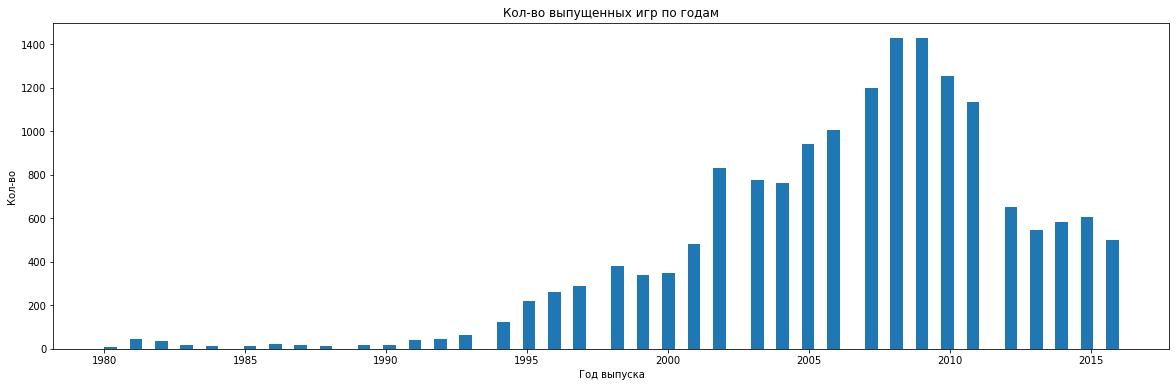

In [15]:
plt.figure(figsize=(20,6))
plt.hist(data['year_of_release'], bins=80)
plt.xlabel('Год выпуска')
plt.ylabel('Кол-во')
plt.title('Кол-во выпущенных игр по годам')
plt.show()

Рост выпуска игр начинается с 1994 года и достигает максимума с 2007 до 2011 года.  
До 1994 года выпуск был минимальным.  
С  2012 года выпуск игр снизился примерно на 43 процента по сравнению с предыдущим годом.  

Для нашего анализа нет смысла брать все года. Оптимально будет взять с 2012 года.  
Так как на протяжении всех лет происходят значительнве скачки в количестве и скорее всего в качестве. 

**3.2 Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Проверим, за какой характерный срок появляются новые и исчезают старые платформы?**

Посмотрим, какие есть платформы:

In [16]:
data['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

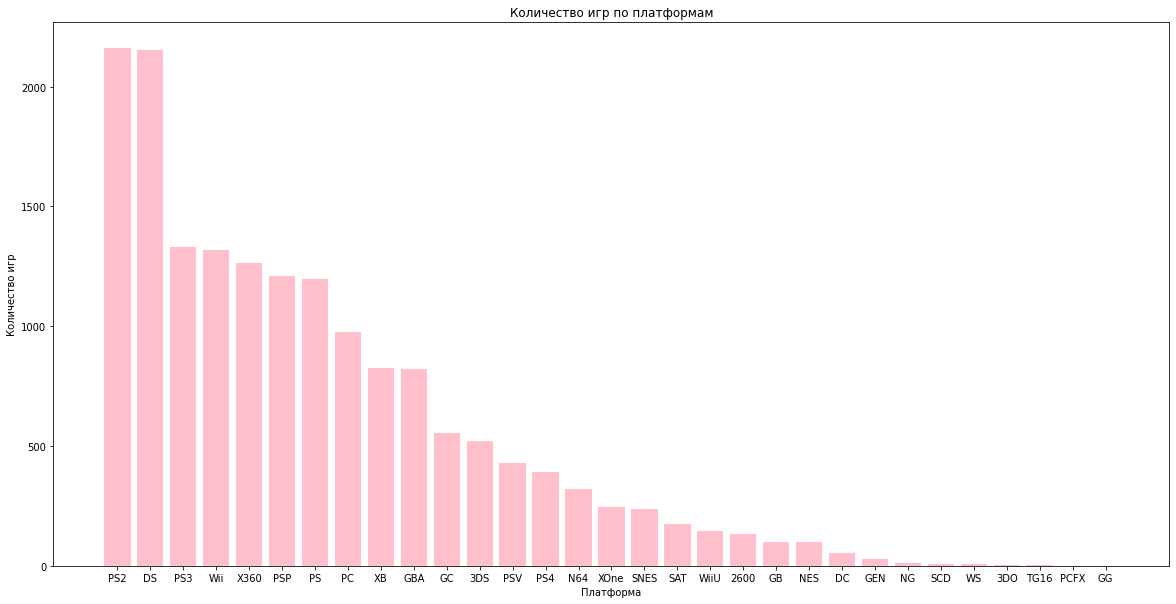

In [17]:
platform_counts = data['platform'].value_counts()

plt.figure(figsize=(20, 10))
plt.bar(platform_counts.index, platform_counts.values, color='pink')
plt.xlabel('Платформа')
plt.ylabel('Количество игр')
plt.title('Количество игр по платформам')
plt.show()

Больше всего игр на платформах PS2 и DS. У них практически одинаковое количество игр.  
Меньше всего GG и PCFX.

Посмотрим 15 максимальных суммарных продаж:

In [18]:
platform_sales = data.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum().sum(axis=1)
top_platforms = platform_sales.sort_values(ascending=False).head(15)
display(top_platforms)

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
dtype: float64

Построим график.

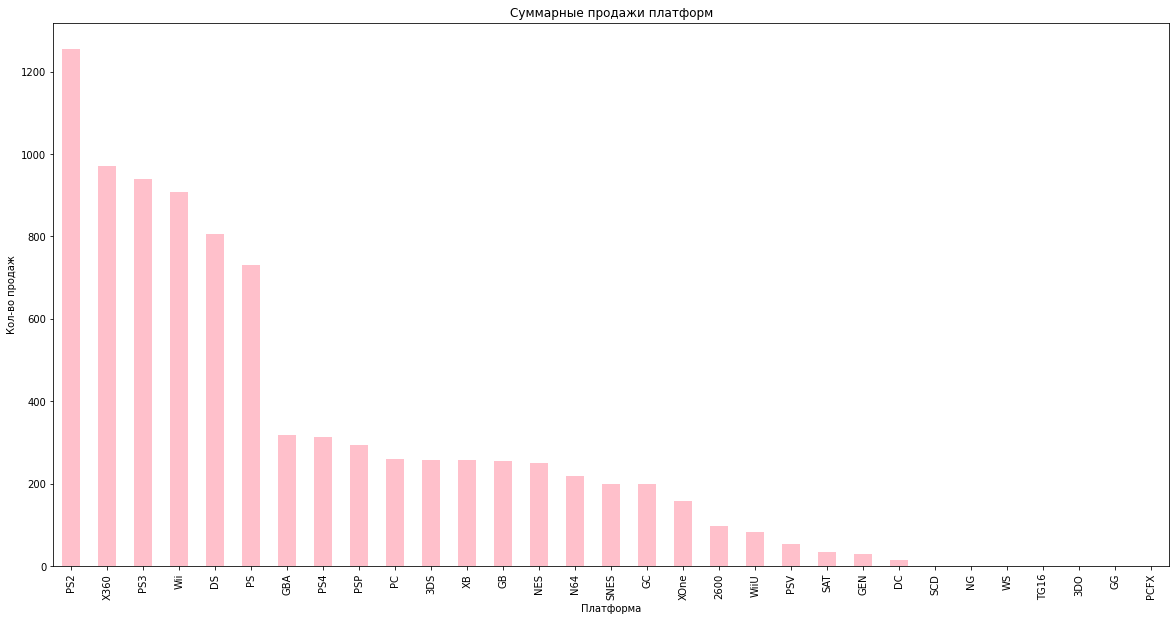

In [19]:
sorted_pivot_table = data.pivot_table(values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], index='platform', aggfunc='sum').sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(20, 10))
sorted_pivot_table.plot(kind='bar', grid=False, color='pink')
plt.title('Суммарные продажи платформ')
plt.xlabel('Платформа')
plt.ylabel('Кол-во продаж')
plt.show()

В обоих случаях PS2 занимает первое место.  
DS занимает второе место по выпуску игр, но 5 место по сумме продаж.  
PS3 в обоих случаях занимает 3 место.

**Сколько лет платформы выпускают игры?**

In [20]:
pl = data.groupby('platform')['year_of_release'].max() - data.groupby('platform')['year_of_release'].min()
pl.sort_values(ascending=False)

platform
PC      31.0
DS      28.0
GB      13.0
X360    11.0
PSP     11.0
PS2     11.0
NES     11.0
DC      10.0
Wii     10.0
PS3     10.0
2600     9.0
SNES     9.0
PS       9.0
XB       8.0
GBA      7.0
GC       6.0
N64      6.0
3DS      5.0
PSV      5.0
SAT      5.0
WiiU     4.0
GEN      4.0
NG       3.0
XOne     3.0
PS4      3.0
WS       2.0
3DO      1.0
SCD      1.0
TG16     0.0
PCFX     0.0
GG       0.0
Name: year_of_release, dtype: float64

In [21]:
pl.describe()

count    31.000000
mean      7.612903
std       6.998464
min       0.000000
25%       3.000000
50%       6.000000
75%      10.000000
max      31.000000
Name: year_of_release, dtype: float64

Есть платформы, которые и года не "проработали". А есть те, кто уже несколько десятков лет радует пользователей новыми играми.  
При этом большинство платформ выпускают игры в течение 6-7 лет.  
Если смотреть на график с количеством игр по годам, то оптимальным будет взять данные с 2012 по 2016 год. Всплеск в период с 2007 по 2011 может говорить о большом количестве экспериментов с разработкой и выпуском игр, с появлением новых технологий, которые не всегда могли быть успешными.

**Создадим новый датафрейм.**

In [22]:
new_data = data.query('year_of_release >= 2012')
display(new_data)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013.0,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012.0,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


**Посмотрим кто сколько продавал по годам.**

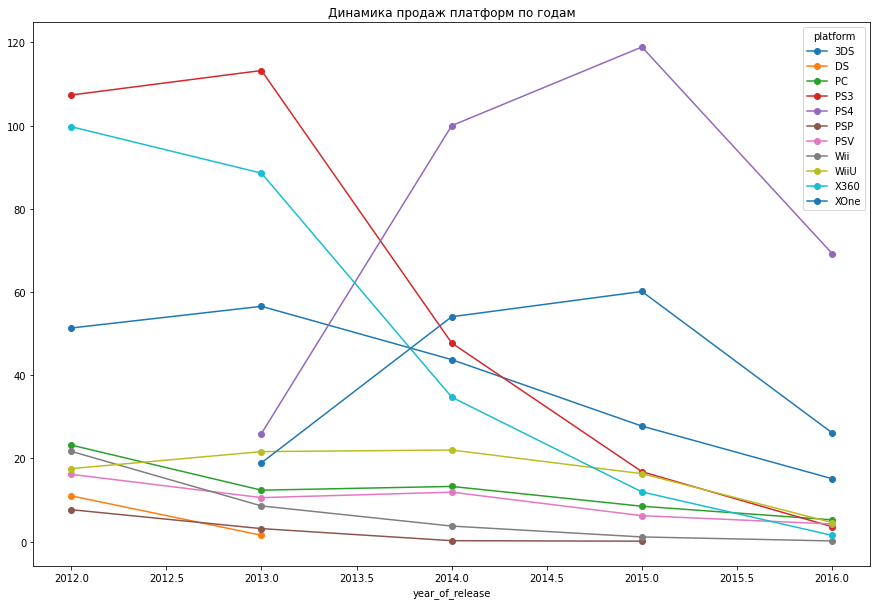

In [38]:
pivot_table = new_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
pivot_table.plot(style='-o', figsize=(15, 10), title='Динамика продаж платформ по годам')
plt.show()

In [28]:
pivot_table_pl_year = new_data.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')
display(pivot_table_pl_year)

year_of_release,2012.0,2013.0,2014.0,2015.0,2016.0
platform,,,,,
3DS,51.36,56.57,43.76,27.78,15.14
DS,11.01,1.54,NaN,NaN,NaN
PC,23.22,12.38,13.28,8.52,5.25
PS3,107.36,113.25,47.76,16.82,3.60
PS4,NaN,25.99,100.00,118.90,69.25
PSP,7.69,3.14,0.24,0.12,NaN
PSV,16.19,10.59,11.90,6.25,4.25
Wii,21.71,8.59,3.75,1.14,0.18
WiiU,17.56,21.65,22.03,16.35,4.60


На графике и таблице видим, что DS, PSP и Wii перестали выпускать игры.  
X360, PS3, WiiU, PC уже на грани полного прекращения выпуска.  

Судя по графику первые 2 года самые активные на выпуск игр. Далее количество идет на спад. Это можем наблюдать у PS4 и 3DS.

**Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат.**

Построим ящик с усами и таблицу для 5 топовых платформ и таблицу для всех.

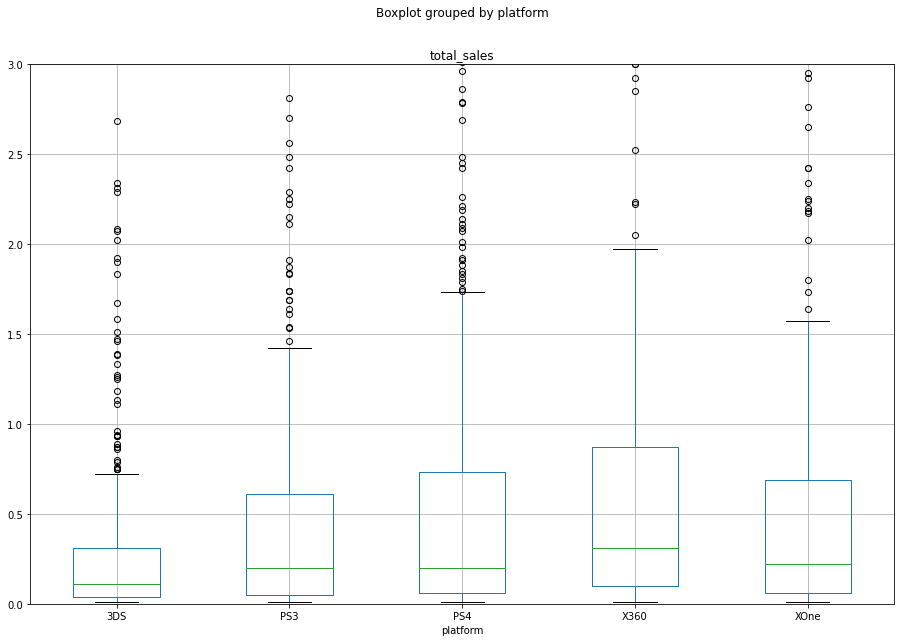

In [70]:
top_pl = new_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index

new_data[new_data['platform'].isin(top_pl)].boxplot(column='total_sales', by='platform', figsize=(15, 10))
plt.ylim(0, 3)
plt.show()

In [82]:
top_pl = new_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5)
top_pl_sales = filtered_data.groupby('platform')['total_sales'].describe()

display(top_pl_sales)

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,396.0,0.491439,1.387161,0.01,0.04,0.11,0.3125,14.60
PS3,493.0,0.585781,1.462855,0.01,0.05,0.20,0.6100,21.05
PS4,392.0,0.801378,1.609456,0.01,0.06,0.20,0.7300,14.63
X360,292.0,0.810068,1.712069,0.01,0.10,0.31,0.8700,16.27
XOne,247.0,0.645020,1.036139,0.01,0.06,0.22,0.6850,7.39


In [81]:
new_data.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,396.0,0.491439,1.387161,0.01,0.0400,0.11,0.3125,14.60
DS,31.0,0.404839,1.439245,0.01,0.0200,0.05,0.1850,8.06
PC,250.0,0.250600,0.494640,0.01,0.0300,0.08,0.2400,5.14
PS3,493.0,0.585781,1.462855,0.01,0.0500,0.20,0.6100,21.05
PS4,392.0,0.801378,1.609456,0.01,0.0600,0.20,0.7300,14.63
PSP,173.0,0.064682,0.071296,0.01,0.0200,0.03,0.0900,0.36
PSV,411.0,0.119659,0.203011,0.01,0.0200,0.05,0.1200,1.96
Wii,54.0,0.655000,1.165447,0.01,0.0625,0.18,0.6875,6.76
WiiU,147.0,0.559116,1.058836,0.01,0.0800,0.22,0.5250,7.09


**Вывод.**

Данные таблицы и ящика с усами показывают, что продажи игр на различных платформах значительно варьируются, и некоторые платформы имеют значительно больше продаж, чем другие. Это может быть связано с различными факторами, включая популярность платформы, качество игр, доступность и другие рыночные условия.

**Влияние оценки пользователей на продажи.**

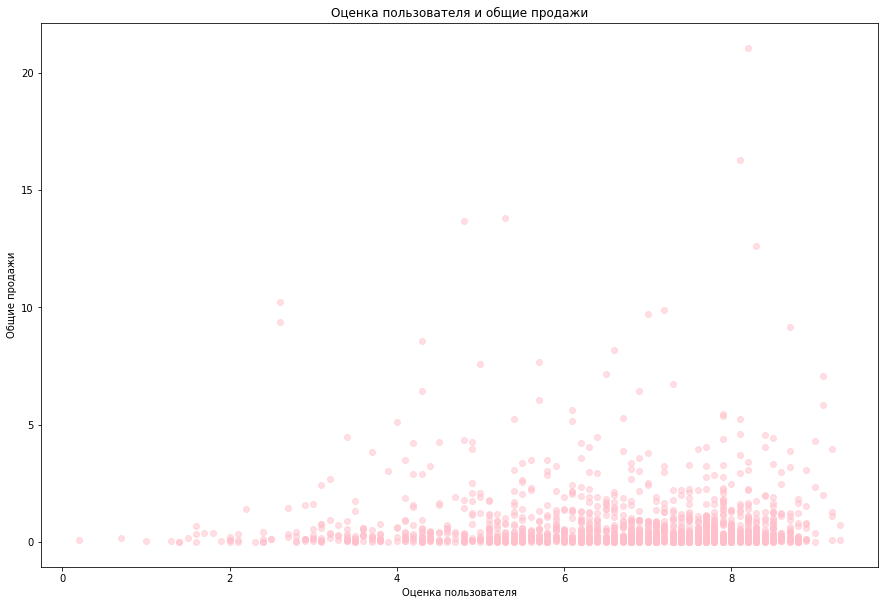

'Корреляция между оценкой пользователя и общими продажами: 0.0044288176754932575'

In [83]:
plt.figure(figsize=(15, 10))
plt.scatter(new_data['user_score'], new_data['total_sales'], alpha=0.5, label='Оценка пользователя', color='pink')
plt.xlabel('Оценка пользователя')
plt.ylabel('Общие продажи')
plt.title('Оценка пользователя и общие продажи')
plt.show()

user_corr = new_data['user_score'].corr(new_data['total_sales'])
display(f"Корреляция между оценкой пользователя и общими продажами: {user_corr}")


**Влияние оценки критиков на продажи.**

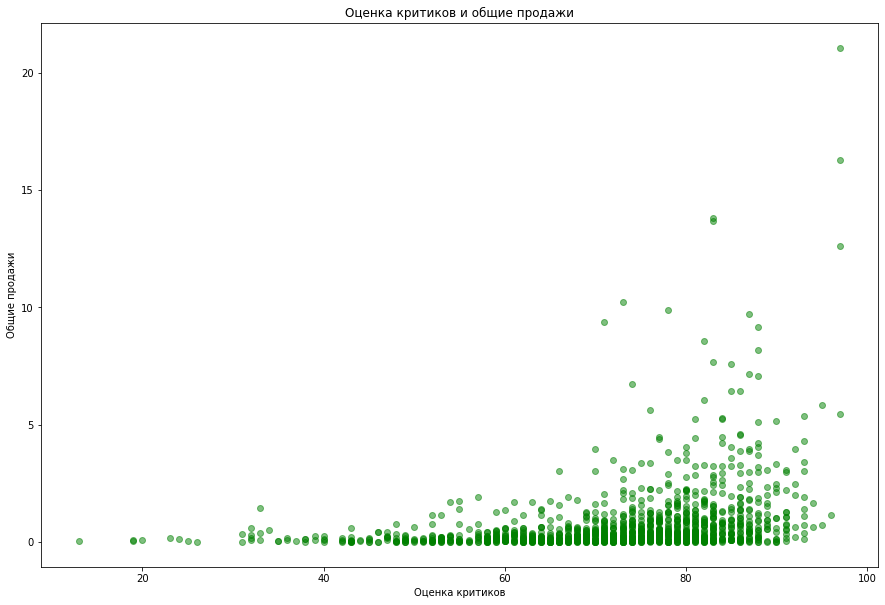

'Корреляция между оценкой критиков и общими продажами: 0.3081967459207781'

In [84]:
plt.figure(figsize=(15, 10))
plt.scatter(new_data['critic_score'], new_data['total_sales'], alpha=0.5, label='Оценка критиков', color='green')
plt.xlabel('Оценка критиков')
plt.ylabel('Общие продажи')
plt.title('Оценка критиков и общие продажи')
plt.show()

critic_corr = new_data['critic_score'].corr(new_data['total_sales'])
display(f"Корреляция между оценкой критиков и общими продажами: {critic_corr}")

**Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.**

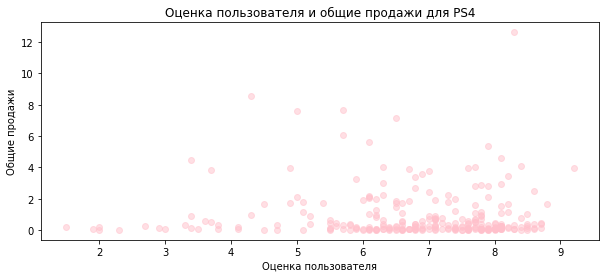

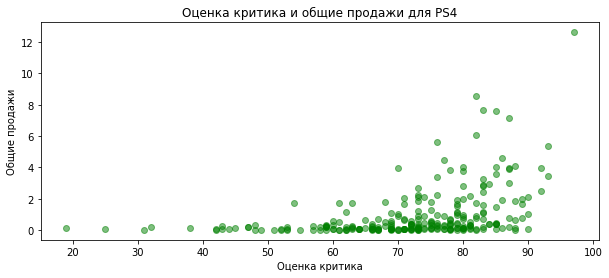

Корреляция между оценкой пользователя и общими продажами для PS4: -0.031957110204556376
Корреляция между оценкой критика и общими продажами для PS4: 0.40656790206178095


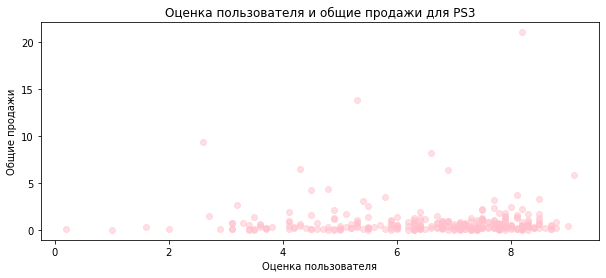

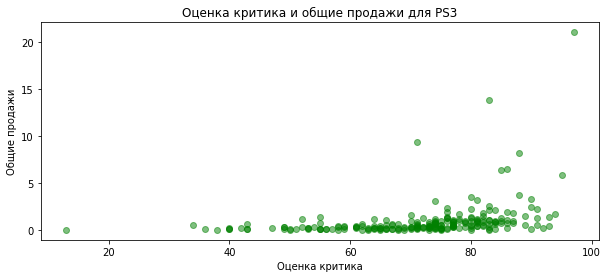

Корреляция между оценкой пользователя и общими продажами для PS3: -0.005143522887113828
Корреляция между оценкой критика и общими продажами для PS3: 0.3314972592629587


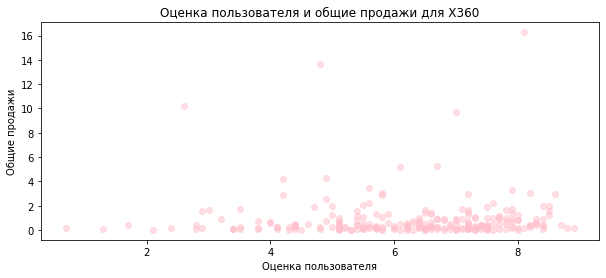

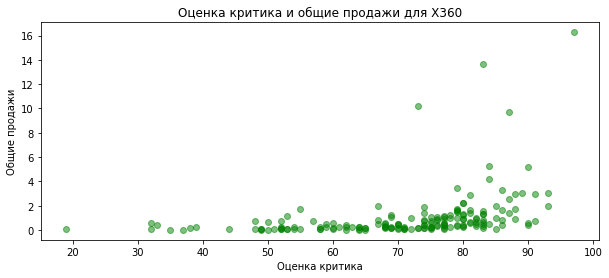

Корреляция между оценкой пользователя и общими продажами для X360: 0.006163978646213326
Корреляция между оценкой критика и общими продажами для X360: 0.3605734888507336


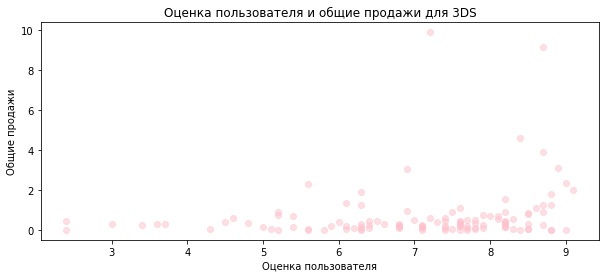

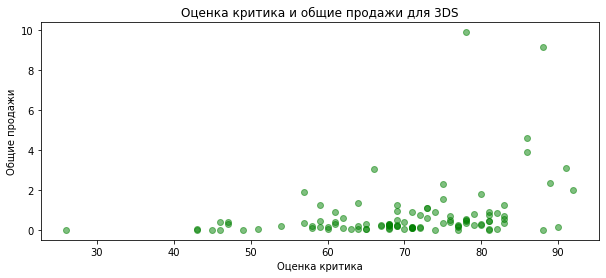

Корреляция между оценкой пользователя и общими продажами для 3DS: 0.19758263411038599
Корреляция между оценкой критика и общими продажами для 3DS: 0.3208028695360785


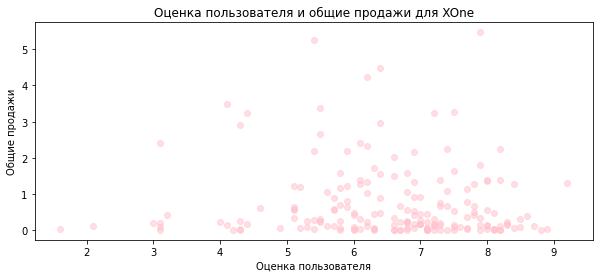

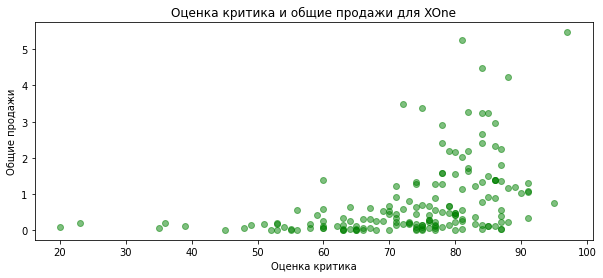

Корреляция между оценкой пользователя и общими продажами для XOne: -0.06892505328279414
Корреляция между оценкой критика и общими продажами для XOne: 0.4169983280084017


In [85]:
top_platforms = new_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index

for platform in top_platforms:
    platform_data = new_data[new_data['platform'] == platform]
    
    plt.figure(figsize=(10, 4))
    plt.scatter(platform_data['user_score'], platform_data['total_sales'], alpha=0.5, label='Оценка пользователя', color='pink')
    plt.xlabel('Оценка пользователя')
    plt.ylabel('Общие продажи')
    plt.title(f'Оценка пользователя и общие продажи для {platform}')
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.scatter(platform_data['critic_score'], platform_data['total_sales'], alpha=0.5, label='Оценка критика', color='green')
    plt.xlabel('Оценка критика')
    plt.ylabel('Общие продажи')
    plt.title(f'Оценка критика и общие продажи для {platform}')
    plt.show()
    
    user_corr = platform_data['user_score'].corr(platform_data['total_sales'])
    print(f"Корреляция между оценкой пользователя и общими продажами для {platform}: {user_corr}")
    
    critic_corr = platform_data['critic_score'].corr(platform_data['total_sales'])
    print(f"Корреляция между оценкой критика и общими продажами для {platform}: {critic_corr}")

**Вывод.**

В рамках проведенной работы можно сделать вывод, что оценка пользователей не имеет большого влияния на продажи игр платформами, корреляция отсутствует.    
При этом оценка критиков имеет слабую положительную корреляцию к продажам. Это может говорить о том, что на продажи есть влиение оценки притиков.  


**Общее распределение игр по жанрам.**

Посмотрим общее количество игр по жанрам.

Action          1031
Role-Playing     370
Adventure        302
Sports           268
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: genre, dtype: int64

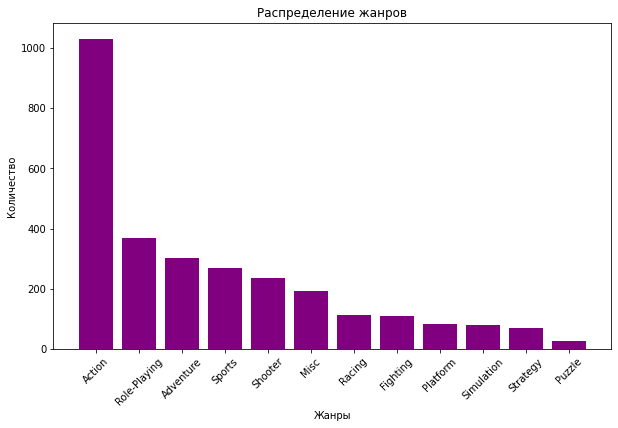

In [86]:
genre_counts = new_data['genre'].value_counts()
display(genre_counts)

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='purple')
plt.xlabel('Жанры')
plt.ylabel('Количество')
plt.title('Распределение жанров')
plt.xticks(rotation=45)
plt.show()

Больше всего игр выпускают в жанре Action. Ниже посмотрим детальнее жанры по 5 самым топовым платформам.

**Посмотрим данные по 5 топовым платформам.**

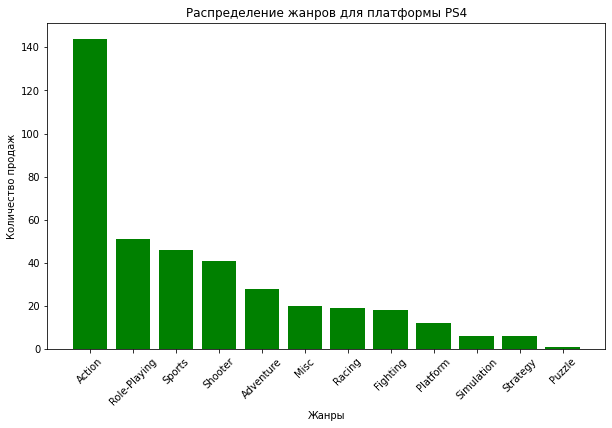

,count,mean,median,sum
genre,,,,
Action,144,0.667361,0.155,96.10
Adventure,28,0.226429,0.070,6.34
Fighting,18,0.480556,0.170,8.65
Misc,20,0.409500,0.075,8.19
Platform,12,0.640833,0.300,7.69
Puzzle,1,0.020000,0.020,0.02
Racing,19,0.638947,0.230,12.14
Role-Playing,51,0.568431,0.200,28.99
Shooter,41,2.160000,0.970,88.56


In [87]:
ps4_data = new_data[new_data['platform'] == 'PS4']

genre_counts = ps4_data['genre'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='green')
plt.xlabel('Жанры')
plt.ylabel('Количество продаж')
plt.title('Распределение жанров для платформы PS4')
plt.xticks(rotation=45)
plt.show()

pivot_table = ps4_data.pivot_table(index='genre', values='total_sales', aggfunc={'count','sum', 'mean', 'median'})
display(pivot_table)

Данные показывают, что жанр "Action" является самым популярным по количеству выпущенных игр, а жанр "Shooter" является самым прибыльным, с наивысшими медианными продажами. 

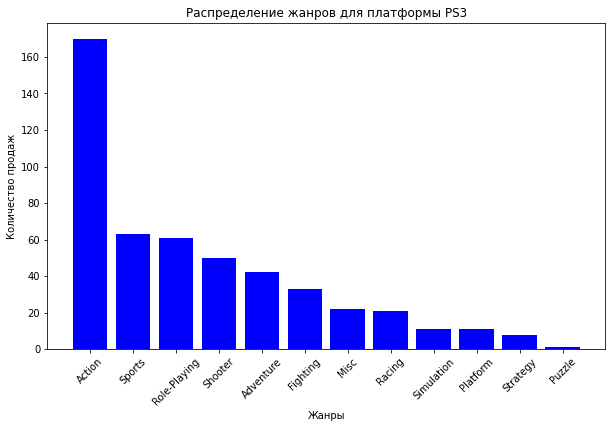

,count,mean,median,sum
genre,,,,
Action,170,0.680882,0.260,115.75
Adventure,42,0.145000,0.050,6.09
Fighting,33,0.333333,0.190,11.00
Misc,22,0.403636,0.075,8.88
Platform,11,0.387273,0.250,4.26
Puzzle,1,0.040000,0.040,0.04
Racing,21,0.550476,0.170,11.56
Role-Playing,61,0.370820,0.160,22.62
Shooter,50,1.207800,0.385,60.39


In [88]:
ps3_data = new_data[new_data['platform'] == 'PS3']

genre_counts = ps3_data['genre'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='blue')
plt.xlabel('Жанры')
plt.ylabel('Количество продаж')
plt.title('Распределение жанров для платформы PS3')
plt.xticks(rotation=45)
plt.show()

pivot_table = ps3_data.pivot_table(index='genre', values='total_sales', aggfunc={'count','sum', 'mean', 'median'})
display(pivot_table)

В PS3 ситуация такая же, как в PS4.

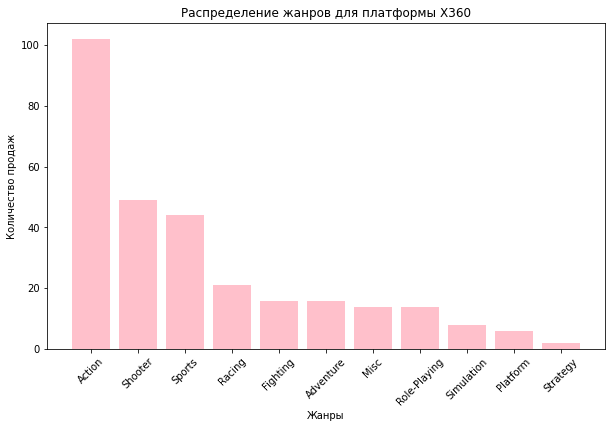

,count,mean,median,sum
genre,,,,
Action,102,0.800000,0.335,81.60
Adventure,16,0.204375,0.075,3.27
Fighting,16,0.310625,0.225,4.97
Misc,14,1.059286,0.270,14.83
Platform,6,0.356667,0.110,2.14
Racing,21,0.400476,0.230,8.41
Role-Playing,14,0.700000,0.490,9.80
Shooter,49,1.483673,0.470,72.70
Simulation,8,0.191250,0.175,1.53


In [89]:
x360_data = new_data[new_data['platform'] == 'X360']

genre_counts = x360_data['genre'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='pink')
plt.xlabel('Жанры')
plt.ylabel('Количество продаж')
plt.title('Распределение жанров для платформы X360')
plt.xticks(rotation=45)
plt.show()

pivot_table = x360_data.pivot_table(index='genre', values='total_sales', aggfunc={'count','sum', 'mean', 'median'})
display(pivot_table)

На платформе X360 снова лидирует жанр Action по количеству игр.  
Однако, медиана прибыли больше всего в жанре Role-Playing при небольшом количестве выпущенных игр.  
Наибольшее среднее значение по продажам показывает жанр Shooter.

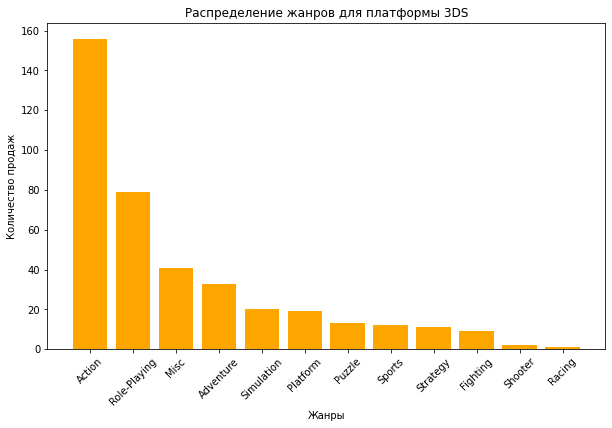

,count,mean,median,sum
genre,,,,
Action,156,0.291603,0.090,45.49
Adventure,33,0.130303,0.060,4.30
Fighting,9,0.940000,0.080,8.46
Misc,41,0.230488,0.110,9.45
Platform,19,1.005789,0.210,19.11
Puzzle,13,0.204615,0.100,2.66
Racing,1,0.280000,0.280,0.28
Role-Playing,79,1.003797,0.220,79.30
Shooter,2,0.065000,0.065,0.13


In [90]:
tds_data = new_data[new_data['platform'] == '3DS']

genre_counts = tds_data['genre'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='orange')
plt.xlabel('Жанры')
plt.ylabel('Количество продаж')
plt.title('Распределение жанров для платформы 3DS')
plt.xticks(rotation=45)
plt.show()

pivot_table = tds_data.pivot_table(index='genre', values='total_sales', aggfunc={'count','sum', 'mean', 'median'})
display(pivot_table)

На платформе 3DS снова лидирует жанр Action по количеству игр. Однако, медиана прибыли больше всего в жанре Racing.  
Наибольшее среднее значение показывает жанр Role-Playing.

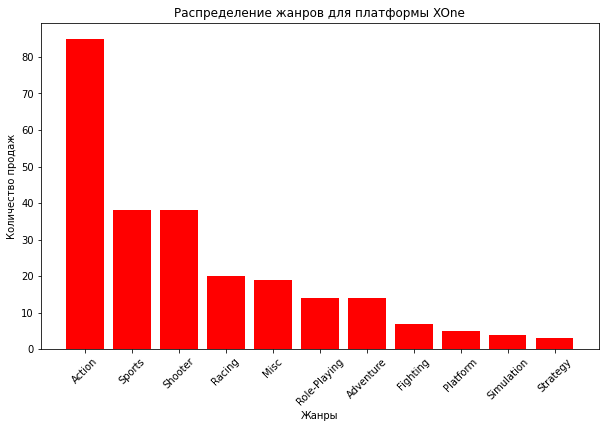

,count,mean,median,sum
genre,,,,
Action,85,0.438941,0.150,37.31
Adventure,14,0.191429,0.060,2.68
Fighting,7,0.350000,0.200,2.45
Misc,19,0.391053,0.180,7.43
Platform,5,0.186000,0.160,0.93
Racing,20,0.489500,0.185,9.79
Role-Playing,14,0.753571,0.320,10.55
Shooter,38,1.587632,1.095,60.33
Simulation,4,0.172500,0.160,0.69


In [91]:
xone_data = new_data[new_data['platform'] == 'XOne']

genre_counts = xone_data['genre'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='red')
plt.xlabel('Жанры')
plt.ylabel('Количество продаж')
plt.title('Распределение жанров для платформы XOne')
plt.xticks(rotation=45)
plt.show()

pivot_table = xone_data.pivot_table(index='genre', values='total_sales', aggfunc={'count','sum', 'mean', 'median'})
display(pivot_table)

Пользователям платформы XOne доступен большой выбр игр в жанре Action. Но прибыли больше приносит жанр Shooter. У него максимальные средние и медианные значения при вдвое меньшем количестве игр, чем у Action.

**Вывод.**

На всех выбранных платформах первое место занимает жанр Action по количеству игр. При этом жанр не занимает лидирующие позиции по продажам.  

Role-Playing, Shooter, Sports оказались самыми прибыльными.  
Большой выпуск жанра Action не всегда приносит высокие доходы. 

Таблица со средними и медианными значениями показывает, что прибыль может быть в несколько раз больше при небольшом количестве игр, чем у Action, которых больше всего на платформах.


**Шаг 4. Составим портрет пользователя каждого региона.**

**4.1 Самые популярные платформы (топ-5).**

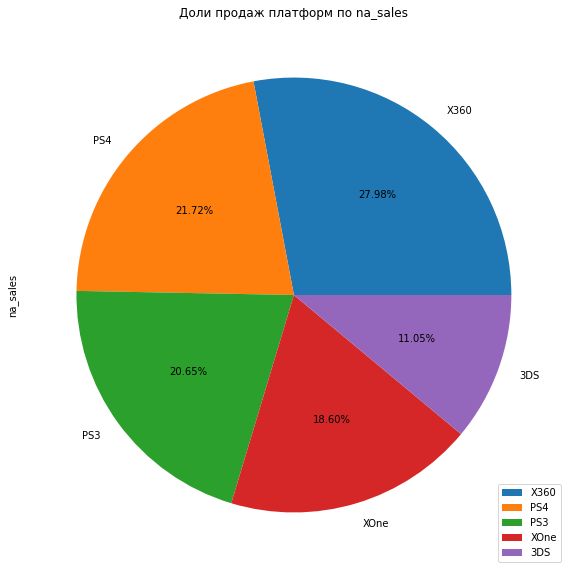

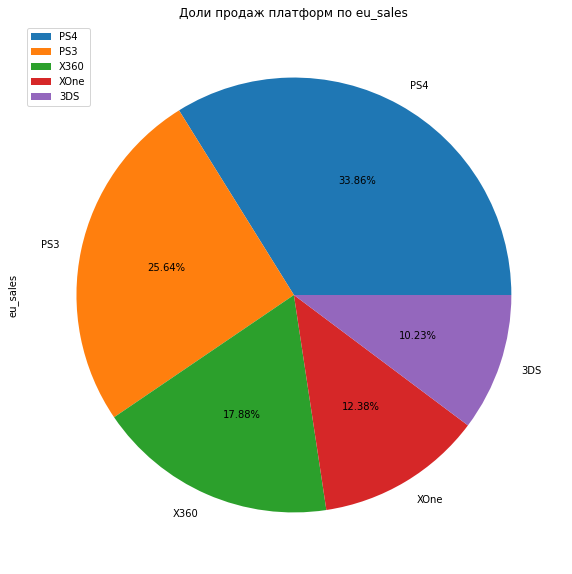

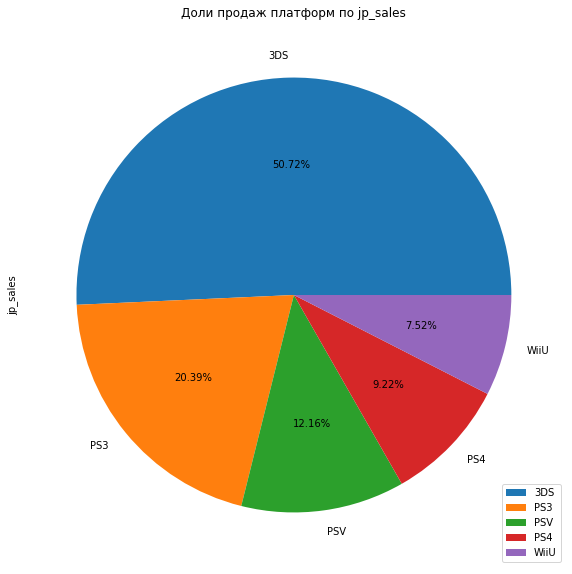

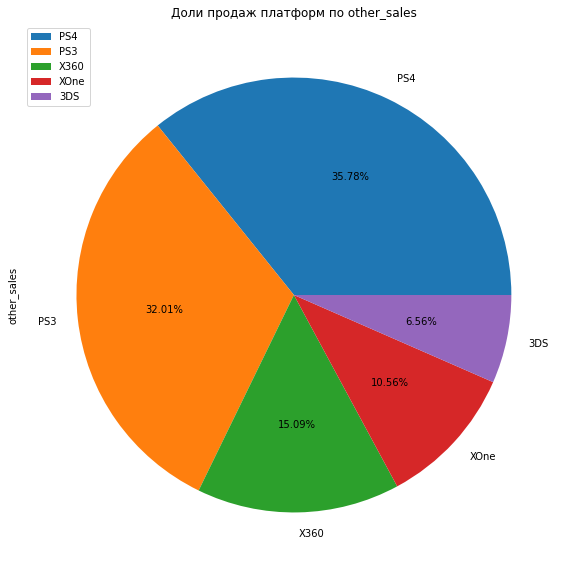

In [92]:
for elem in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    (new_data.groupby(by='platform').agg({elem :'sum'}).sort_values(by=elem, ascending=False).head(5)
    .plot(kind='pie', subplots=True, figsize=(10,10), autopct='%1.2f%%'))
    plt.title(f'Доли продаж платформ по {elem}')
    plt.show()

**Вывод.**

Диаграмма показала следующие результаты:  

Популярные платформы Северной Америки:  
* Доля X360 составляет 27.98%.  
* Доля PS4 составляет 21.72%.  
* Доля PS3 составляет 20.65%.  
* Доля XOne составляет 18.60%.  
* Доля 3DS составляет 11.05%.  

Популярные платформы в Европе:
* Доля PS4 составляет 33.86%.
* Доля PS3 составляет 25.64%.
* Доля X360 составляет 17.88%.  
* Доля Xone составляет 12.38%.
* Доля 3DS составляет 10.23%.

Популярные платформы в Японии:
* Доля 3DS составляет 50.72%.
* Доля PS3 составляет 20.39%.
* Доля PSV составляет 12.16%.
* Доля PS4 составляет 9.22%.
* Доля WiiU составляет 7.52%.

Популярные платформы в других регионах:
* Доля PS4 составляет 35.78%.
* Доля PS3 составляет 32.01%.
* Доля X360 составляет 15.09%.
* Доля XOne составляет 10.56%.
* Доля 3DS составляет 6.56%.

В каждом регионе своя любимая платформа. При этом почти все 5 платформ повторяются.

**4.2 Самые популярные жанры (топ-5).**

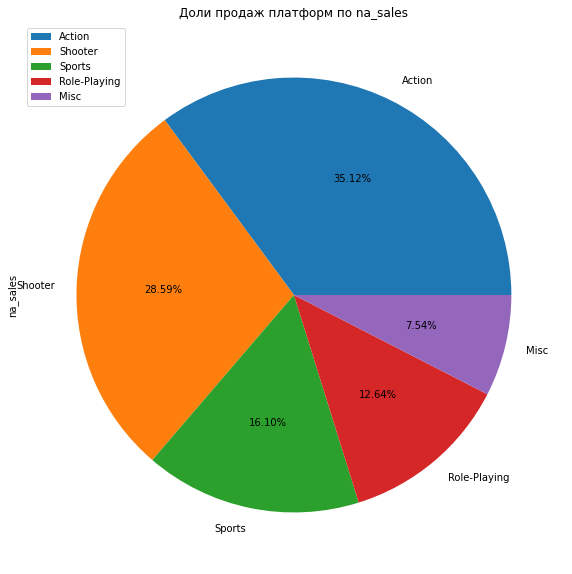

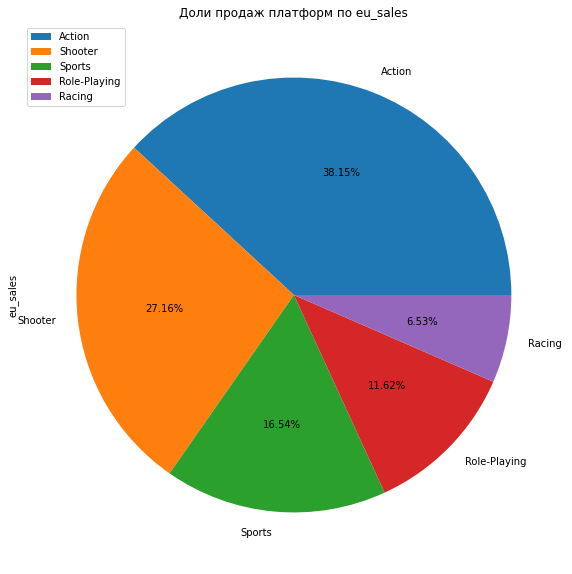

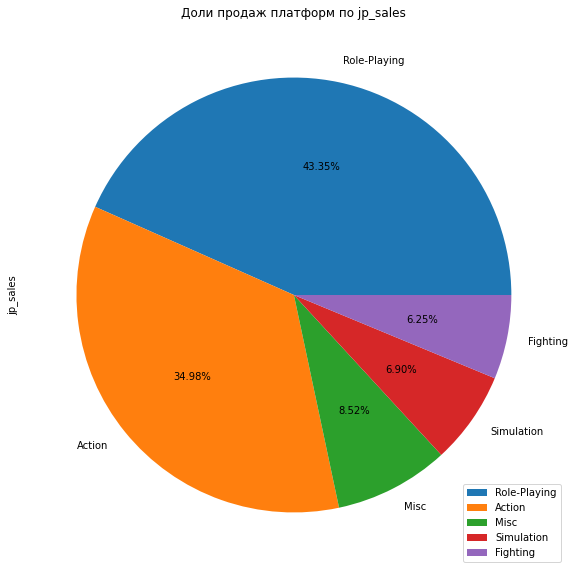

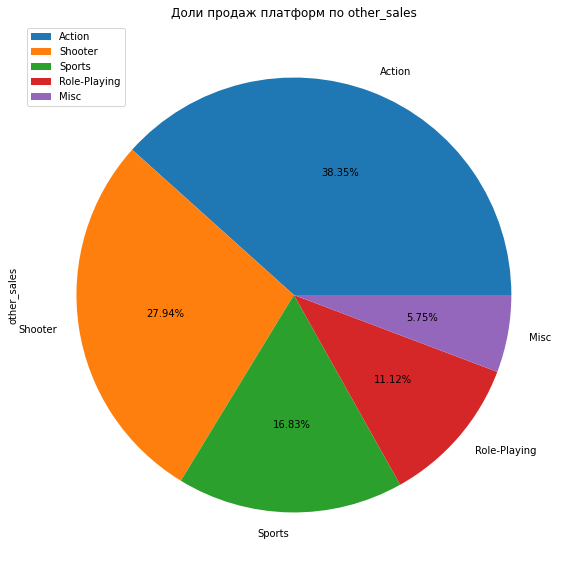

In [93]:
for elem in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    (new_data.groupby(by='genre').agg({elem :'sum'}).sort_values(by=elem, ascending=False).head(5)
    .plot(kind='pie', subplots=True, figsize=(10,10), autopct='%1.2f%%'))
    plt.title(f'Доли продаж платформ по {elem}')
    plt.show()

**Вывод.**

Диаграмма показала следующие результаты:  

Популярные платформы Северной Америки:  
* Доля Action составляет 35.12%.  
* Доля Shooter составляет 28.59%.  
* Доля Sports составляет 16.10%.  
* Доля Role-Playing составляет 12.64%.  
* Доля Misc составляет 7.54%.  

Популярные платформы в Европе:
* Доля Action составляет 38.15% .
* Доля Shooter составляет 27.16%.
* Доля Sports составляет 16.54%.  
* Доля Role-Playing составляет 11.62%.
* Доля Racing составляет 6.53%.

Популярные платформы в Японии:
* Доля Role-Playing составляет 43.35%.
* Доля Action составляет 34.98%.
* Доля Misc составляет 8.52%.
* Доля Simulation составляет 6.90%
* Доля Fighting составляет 6.25%.

Популярные платформы в других регионах:
* Доля Action составляет 38.35%.  
* Доля Shooter составляет 27.94%.  
* Доля Sports составляет 16.83%.  
* Доля Role-Playing составляет 11.12%.  
* Доля Misc составляет 5.75%.  



**4.3 Влияет ли рейтинг ESRB на продажи в отдельном регионе?**

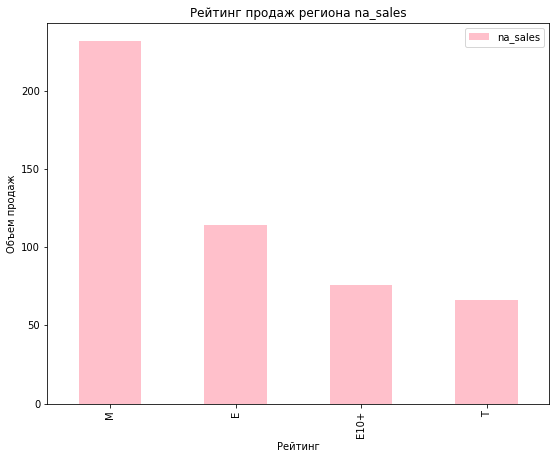

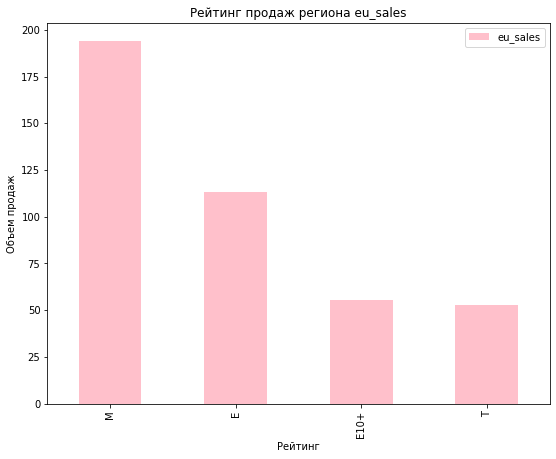

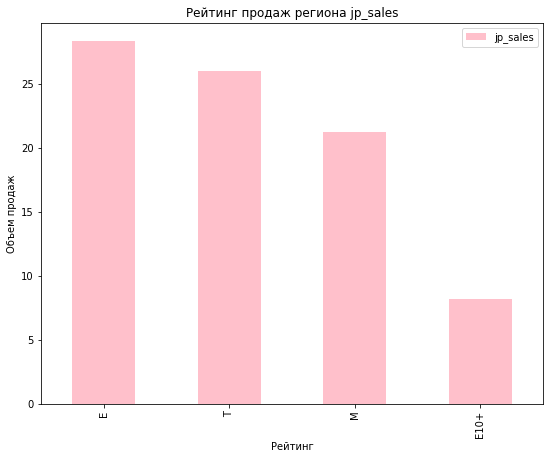

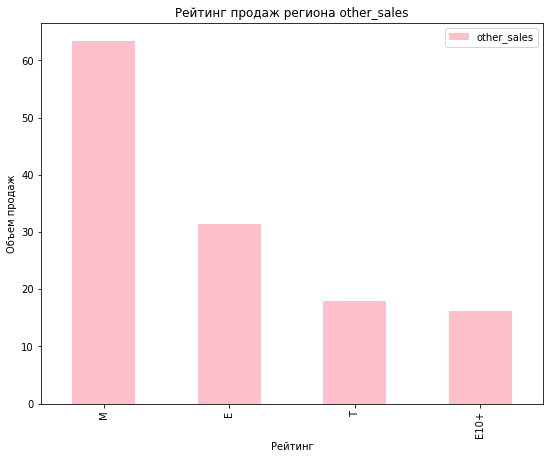

In [94]:
for elem in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    (new_data.groupby(by='rating').agg({elem :'sum'}).sort_values(by=elem, ascending=False)
    .plot(kind='bar', figsize=(9,7), grid=False, color='pink'))
    plt.title(f'Рейтинг продаж региона {elem}')
    plt.xlabel('Рейтинг')
    plt.ylabel('Объем продаж')
    plt.show()
    

**Вывод.**

На основании графиков можем сделать следующие выводы:

1. Жители Северной Америки и Европы однаково смотрят на рейтинг игр. Различие только в количестве продаж.
* Первое место занимает рейтинг М.  
* Второе место рейтинг Е.  
* Игры без рейтинга расположились на 3 месте.  
* Четвертое место рейтинг E10+.
* Рейтинг Teen располжился на последнем пятом месте.  

2. В остальных регионах первые 3 места расположились, как в Северной Америке и Европе:
* Четвертое место рейтинг T.
* Пятое место рейтинг E10+.

3. Распределение в Японии:
* Игры без рейтинга расположились на первом месте. 
* Второе место рейтинг Е.
* Далее рейтинг T.
* Четвертое место рейтинг M.
* Пятое место рейтинг E10+.


**Шаг 5. Проверим гипотезы.**

**5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

Нулевая гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
Альтернативная гипотеза - средние пользовательские рейтинги платформ Xbox One и PC разные.  

In [95]:
xone_rat = data.query('(user_score >= 0) & (platform == "XOne")')['user_score']
pc_rat = data.query('(user_score >= 0) & (platform == "PC")')['user_score']

In [96]:
average_pl = data.groupby('platform')['user_score'].mean()
display(average_pl.loc[['XOne', 'PC']])

platform
XOne    6.521429
PC      7.065960
Name: user_score, dtype: float64

In [97]:
results = st.ttest_ind(xone_rat, pc_rat, equal_var = False)
alpha = 0.05

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не можем отвергнуть нулевую гипотезу")

p-значение: 4.5385802963771835e-06
Отвергаем нулевую гипотезу


Нулевая гипотеза предполагает, что средняя пользовательская оценка для двух платформ равна. Для альтернативной гипотезы взяли другое мнение.  
Для проверки гипотез учитываем данные за все время. Поэтому отсеяли пропущенные отсутствующие значения.  
Далее проверили средние значения оценки для двух платформ.  
По результатам проверки гипотезы - нулевую гипотезу отвергаем. Рейтинги не равны.

Для сравнения посмотрим данные с 2012 по 2016 год.

In [98]:
xone_rat = new_data.query('(user_score >= 0) & (platform == "XOne")')['user_score']
pc_rat = new_data.query('(user_score >= 0) & (platform == "PC")')['user_score']

In [99]:
average_pl = new_data.groupby('platform')['user_score'].mean()
display(average_pl.loc[["XOne", "PC"]])

platform
XOne    6.521429
PC      6.428641
Name: user_score, dtype: float64

In [100]:
results = st.ttest_ind(xone_rat, pc_rat, equal_var = False)
alpha = 0.05

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не можем отвергнуть нулевую гипотезу")

p-значение: 0.5489537965134912
Не можем отвергнуть нулевую гипотезу


На основе данных за 2012-2016 год итог противоположный. Нулевую гипотезу отвергнуть не можем.

**5.2 Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

Нулевая гипотеза - средние пользовательские рейтинги жанров Action и Sports одинаковые.  
Альтернативная гипотеза - средние пользовательские рейтинги жанров Action и Sports разные.

In [101]:
action_rat = data.query('(user_score >= 0) & (genre == "Action")')['user_score']
sports_rat = data.query('(user_score >= 0) & (genre == "Sports")')['user_score']

In [102]:
average_pl = data.groupby('genre')['user_score'].mean()
display(average_pl.loc[["Action", "Sports"]])

genre
Action    7.058129
Sports    6.951434
Name: user_score, dtype: float64

In [103]:
results = st.ttest_ind(action_rat, sports_rat, equal_var=False)

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не можем отвергнуть нулевую гипотезу")

p-значение: 0.07370217419278526
Не можем отвергнуть нулевую гипотезу


Здесь, как и в прошлом случае взяли данные за все время и по альтернативной гипотезе средние рейтинги не равны.  
В данном случае отвергнуть нулевую гипотезу не можем. 

Для сравнения посмотрим данные с 2012 по 2016 год.

In [104]:
action_rat = new_data.query('(user_score >= 0) & (genre == "Action")')['user_score']
sports_rat = new_data.query('(user_score >= 0) & (genre == "Sports")')['user_score']

In [105]:
average_pl = new_data.groupby('genre')['user_score'].mean()
display(average_pl.loc[["Action", "Sports"]])

genre
Action    6.825048
Sports    5.455897
Name: user_score, dtype: float64

In [106]:
results = st.ttest_ind(action_rat, sports_rat, equal_var=False)

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не можем отвергнуть нулевую гипотезу")

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


По данным за период с 2012 по 2016 год картина противоположная - нулевая теория была отвергнута.

# Вывод по проведенной работе.

На первом этапе была проведена предобработка данных:  
* привели названия столбцов к нижнему регистру.  
* проверили пропуски в данных. Они были удалены, либо заполнены. Большая часть пропусков осталась, так как их заполнение может исказить результат.  
* скорректировали тип данных столбцов.  
* узнали, что игры в выгрузке с 1980 до 2016 года выпуска.  
* проверили отсутствие дубликатов.  
* добавили столбец с суммарными продажами по всем регионам. 

После более детального анализа выяснено:
1. Рост выпуска игр начинается с 1994 года и достигает максимума с 2007 до 2011 года.  
2. До 1994 года выпуск игр был минимальным.  
3. С  2012 года выпуск игр снизился примерно на 43 процента по сравнению с предыдущим годом.  
4. Для анализа был выбран период с 2012 по 2016 год.
5. Большинство платформ выпускают игры в течение 6-7 лет. При этом есть те, кто выпускает игры уже несколько десятков лет.  
6. DS, PSP и Wii перестали выпускать игры в период с 2013 до 2016 года. X360, PS3, WiiU, PC уже на грани полного прекращения выпуска. 
7. Первые 2 года большинства компаний самые активные в вопросе выпуска игр. Далее количество идет на спад.
8. Оценка пользователей не имеет большого влияния на продажи игр платформами.
9. При этом оценка критиков имеет небольшое влияние.
10. Большой выпуск жанра Action не всегда приносят высокие доходы. Самое большое количество игр в жанре Action. Но он не самый прибыльный. Shooter показывает более лучшие результаты по продажам.
11. В каждом регионе свои популярные платформы игр и жанры:
   * Северная Америка предпочитает платформу X360  и жанр Action. Популярный рейтинг игр М.
   * В Европе популярна платформа  PS4 и жанр Action. Популярный рейтинг игр М.
   * Япония отдает предпочтение платформе 3DS и жанру Role-Playing. Игры выбирают в основном без рейтинга.
   * Остальные страны выбирают PS4, жанр Action и рейтинг М.
   
Проверили ряд гипотез. Результаты следующие:
* Отвергли гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые за весь период данных.
* Но за период с 2012 по 2016 год эту гипотезу отвергнуть не смогли.
     
     
* Не смогли отвергнуть гипотезу, что средние пользовательские рейтинги жанров Action и Sports одинаковые за весь период данных.
* Но за период с 2012 по 2016 год эту гипотезу отвергли.